In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric import nn as gnn

from graph_vae import GraphVAE
from train import train_loop, loss_infer
from data_load import *

## Model Definition and training

In [2]:
net = GraphVAE(3, 32, 8)

In [3]:
train_loop(net, 1, 100)

tensor(17458.7617, grad_fn=<AddBackward0>)
tensor(3760.3674, grad_fn=<AddBackward0>)
tensor(4445.9570, grad_fn=<AddBackward0>)
tensor(1709.0088, grad_fn=<AddBackward0>)
tensor(865.3027, grad_fn=<AddBackward0>)
tensor(869.9142, grad_fn=<AddBackward0>)
tensor(1018.0605, grad_fn=<AddBackward0>)
tensor(1020.2689, grad_fn=<AddBackward0>)
tensor(830.9327, grad_fn=<AddBackward0>)
tensor(1081.3490, grad_fn=<AddBackward0>)
tensor(1198.4775, grad_fn=<AddBackward0>)
tensor(820.4479, grad_fn=<AddBackward0>)
tensor(1066.0054, grad_fn=<AddBackward0>)
tensor(693.0328, grad_fn=<AddBackward0>)
tensor(759.8748, grad_fn=<AddBackward0>)
tensor(853.5504, grad_fn=<AddBackward0>)
tensor(841.3351, grad_fn=<AddBackward0>)
tensor(773.8970, grad_fn=<AddBackward0>)
tensor(783.3469, grad_fn=<AddBackward0>)
tensor(689.9230, grad_fn=<AddBackward0>)
tensor(610.6694, grad_fn=<AddBackward0>)
tensor(784.0884, grad_fn=<AddBackward0>)
tensor(687.3868, grad_fn=<AddBackward0>)
tensor(742.4551, grad_fn=<AddBackward0>)
tensor

In [4]:
torch.save(net.state_dict(), "Saves/L_50k.pth")

## Inference and tests

In [2]:
from data_load import get_train_dataset

In [3]:
net = GraphVAE(3, 32, 8)
net.load_state_dict(torch.load("Saves/L_50k.pth"))

<All keys matched successfully>

In [4]:
dataset = get_train_dataset(10_000)
dataloader = torch.utils.data.DataLoader(dataset, 200, True)

In [5]:
for (x,) in dataloader:
    img1 = x[:, :, :, 1]
    L, img2, mask = loss_infer(net, x)
    break

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [7]:
img1 = img1.detach()
img2 = y.detach()

In [16]:
(img2[0]>0).sum()

tensor(0)

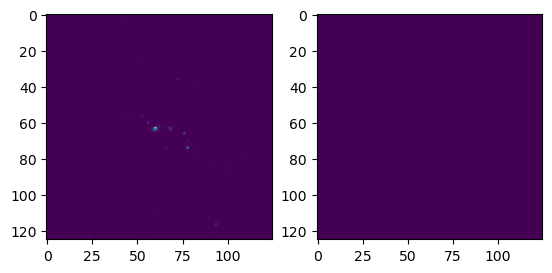

In [14]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1[0]*(256/5))
ax[1].imshow(img2[0]*(256/5))
plt.show()

In [8]:
X, mask = to_dense_batch(G, lengs, fill_value=0, max_num_nodes=1000)
A = to_dense_adj(E, lengs, max_num_nodes=1000) # (batch, 1000, 1000)


In [9]:
X = X
A = A
X.shape, A.shape

(torch.Size([2, 1000, 3]), torch.Size([2, 1000, 1000]))

In [12]:
net = GraphVAE(3, 16, 3)
net

GraphVAE(
  (sage): ModuleList(
    (0): DenseSAGEConv(3, 16)
    (1): DenseSAGEConv(16, 16)
    (2): DenseSAGEConv(16, 3)
  )
  (drop): ModuleList(
    (0): Dropout(p=0.5, inplace=False)
    (1): Dropout(p=0.4, inplace=False)
    (2): Dropout(p=0.3, inplace=False)
  )
  (batch_norm): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): ModuleList(
    (0): MinCut_Pool(
      (linear): Linear(in_features=16, out_features=500, bias=True)
    )
    (1): MinCut_Pool(
      (linear): Linear(in_features=16, out_features=250, bias=True)
    )
  )
  (tr_mu): Linear(in_features=3, out_features=16, bias=True)
  (tr_var): Linear(in_features=3, out_features=16, bias=True)
  (tr_rev): Linear(in_features=16, out_features=3, bias=True)
  (revsage): ModuleList(

In [42]:
Z, A, mu, logvar, L1, L2 = net(X, A)

In [43]:
Z.shape, A.shape

(torch.Size([2, 1000, 3]), torch.Size([2, 1000, 1000]))